# Step0: Import packages and preparing the data
Carefully make sure you `data_dir` can get the right RESP and HEA data!

In [1]:
%pip install wfdb
%pip install numba
%pip install xlrd 
%pip install os 

import numba
import os
import numpy as np
import matplotlib.pyplot as plt
import wfdb # read Physionet/picsdb file format
import xlrd
from scipy.signal import welch, butter, filtfilt
from wfdb import processing
from numba import jit

data_dir = "E:\\WOA7015\\WOA7015-EDA\\picsdb_data\\1.0.0"

Looking in indexes: http://mirrors.aliyun.com/pypi/simple/
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: http://mirrors.aliyun.com/pypi/simple/
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: http://mirrors.aliyun.com/pypi/simple/
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os


Looking in indexes: http://mirrors.aliyun.com/pypi/simple/
Note: you may need to restart the kernel to use updated packages.


In [2]:
# outside functions
def bp_filter(x, fs, f_lo, f_hi):
    """
    implement digital band-pass filter
    6-th order Butterworth filter, zero-phase implementation
    """
    f_Ny = fs/2
    b_lo = f_lo / f_Ny
    b_hi = f_hi / f_Ny
    # filter parameters
    p_lp = {'N': 6, 'Wn': b_hi, 'btype': 'lowpass',
            'analog': False, 'output': 'ba'}
    p_hp = {'N': 6, 'Wn': b_lo, 'btype': 'highpass',
            'analog': False, 'output': 'ba'}
    bp_b1, bp_a1 = butter(**p_lp)
    bp_b2, bp_a2 = butter(**p_hp)
    x_filt = filtfilt(bp_b1, bp_a1, x, axis=0)
    x_filt = filtfilt(bp_b2, bp_a2, x_filt, axis=0)
    return x_filt


def interval_stats(ts, dt):
    """
    Inputs:
    ts, array of time points, e.g. local maxima of oscillating curve
    dt: sampling interval in seconds
    """
    dts = np.diff(ts)*dt
    mn = dts.min()
    mx = dts.max()
    mu = dts.mean()
    mu_freq = 1/mu
    sd = dts.std()
    q25 = np.percentile(dts, 25)
    q75 = np.percentile(dts, 75)
    print(f"Interval stats (n={len(dts):d}) :")
    print(f"min: {mn:.2f} sec")
    print(f"max: {mx:.2f} sec")
    print(f"mean: {mu:.2f} sec (= {mu_freq:.2f} Hz)")
    print(f"std: {sd:.2f} sec")
    print(f"q25: {q25:.2f} sec")
    print(f"q75: {q75:.2f} sec")
    return dts


def load_segments(filename, verbose=True):
    """
    Load filter and threshold parameters from .xlsx file
    dictionary of subjects and segments, processing parameters
    """
    w = xlrd.open_workbook(filename)
    R = w.sheet_by_name("Sheet1")
    #print(f"Excel document: rows = {R.nrows:d}, cols = {R.ncols:d}")
    # get number of segments
    n_segments = R.nrows-1
    segments = {}
    subj_set = set()  # count unique subject IDs
    for i in range(1, n_segments+1):
        a, b = str(R.cell_value(i, 0)).split(".")
        i_subj = int(a)
        i_seg = int(b)
        if verbose:
            print(f"\nsubject: {i_subj:d}, segment: {i_seg:d}")
        key_subj = f"infant{i_subj:d}"
        key_seg = f"segment{i_seg:d}"
        if i_subj not in subj_set:
            # start new sub-dictionary for each subject
            segments[key_subj] = {}
        segments[key_subj][key_seg] = {}
        subj_set.add(i_subj)
        # segment start (on) and stop (off) indices
        segments[key_subj][key_seg]['on'] = int(R.cell_value(i, 1))
        segments[key_subj][key_seg]['off'] = int(R.cell_value(i, 2))
        # ECG band-pass frequencies
        segments[key_subj][key_seg]['freq_lo_ecg'] = float(R.cell_value(i, 3))
        segments[key_subj][key_seg]['freq_hi_ecg'] = float(R.cell_value(i, 4))
        # RESP band-pass frequencies
        segments[key_subj][key_seg]['freq_lo_resp'] = float(R.cell_value(i, 5))
        segments[key_subj][key_seg]['freq_hi_resp'] = float(R.cell_value(i, 6))
        # ECG & RESP thresholds
        segments[key_subj][key_seg]['thr_ecg'] = float(R.cell_value(i, 7))
        segments[key_subj][key_seg]['thr_resp'] = float(R.cell_value(i, 8))
        # maximum peak-to-peak frequency for ECG & RESP
        segments[key_subj][key_seg]['f_max_ecg'] = float(R.cell_value(i, 9))
        segments[key_subj][key_seg]['f_max_resp'] = float(R.cell_value(i, 10))
        if verbose:
            print(f"on: {segments[key_subj][key_seg]['on']:d}")
            print(f"off: {segments[key_subj][key_seg]['off']:d}")
            print(
                f"freq_lo_ecg: {segments[key_subj][key_seg]['freq_lo_ecg']:.3f}")
            print(
                f"freq_hi_ecg: {segments[key_subj][key_seg]['freq_hi_ecg']:.3f}")
            print(
                f"freq_lo_resp: {segments[key_subj][key_seg]['freq_lo_resp']:.3f}")
            print(
                f"freq_hi_resp: {segments[key_subj][key_seg]['freq_hi_resp']:.3f}")
            print(f"thr_ecg: {segments[key_subj][key_seg]['thr_ecg']:.3f}")
            print(f"thr_resp: {segments[key_subj][key_seg]['thr_resp']:.3f}")
            print(f"f_max_ecg: {segments[key_subj][key_seg]['f_max_ecg']:.3f}")
            print(
                f"f_max_resp: {segments[key_subj][key_seg]['f_max_resp']:.3f}")
    return segments


def load_waveforms(data_dir, infant_index, verbose=True):
    """
    load ECG/RESP waveforms, return as arrays, return sampling freqs
    """
    file_ecg = f"infant{infant_index:d}_ecg"
    file_resp = f"infant{infant_index:d}_resp"
    record_ecg = wfdb.rdrecord(os.path.join(data_dir, file_ecg))
    record_resp = wfdb.rdrecord(os.path.join(data_dir, file_resp))
    d_ecg = record_ecg.__dict__
    d_resp = record_resp.__dict__
    fs_ecg = d_ecg['fs']  # ECG sampling rate in Hz
    fs_resp = d_resp['fs']  # RESP sampling rate in Hz
    x_ecg = d_ecg['p_signal'].ravel()
    x_resp = d_resp['p_signal'].ravel()
    if verbose:
        print("Loading ECG file: ", file_ecg)
        print("Loading RESP file: ", file_resp)
        #print("ECG record: ", d_ecg['record_name'])
        #print("number of signals: ", d_ecg['n_sig'])
        #print("sampling frequency: ", d_ecg['fs'], "Hz")
        #print("Number of samples: ", d_ecg['sig_len'])
        #print("Signal name: ", d_ecg['sig_name'])
        #print("RESP record: ", d_resp['record_name'])
        #print("number of signals: ", d_resp['n_sig'])
        #print("sampling frequency: ", d_resp['fs'], "Hz")
        #print("Number of samples: ", d_resp['sig_len'])
        #print("Signal name: ", d_resp['sig_name'])
        print("ECG sampling frequency: ", fs_ecg, " Hz")
        print("RESP sampling frequency: ", fs_resp, " Hz")
    return x_ecg, x_resp, fs_ecg, fs_resp


def locmax(x):
    p = 1 + np.where(np.diff(np.sign(np.diff(x))) == -2)[0]
    return p


def p_hat(x, n_bins=50, method='histogram'):
    """
    Histogram / kernel estimate of p(r)
    method = 'histogram', 'kernel'
    """
    x_max = x.max()
    if method == 'histogram':
        x_bins = np.linspace(0, x_max, num=n_bins, endpoint=True)
        p_hat, _ = np.histogram(x, bins=x_bins, density=True)
        p_hat /= p_hat.sum()
        x_ax = 0.5*(x_bins[:-1] + x_bins[1:])  # correct n_bins+1 issue
    if method == 'kernel':
        # gaussian, tophat, epanechnikov, exponential, linear, cosine
        kde = KernelDensity(bandwidth=0.25, kernel='epanechnikov')
        kde.fit(x[:, None])
        x_ax = np.linspace(0, x_max, num=n_bins, endpoint=True)
        log_p = kde.score_samples(x_ax[:, None])
        p_hat = np.exp(log_p)
        p_hat /= p_hat.sum()
    return x_ax, p_hat


def poincare_plot(I, I_min=None, I_max=None, doplot=False):
    """
    Construct Poincaré plot, get principal axes of main cloud
    Arguments:
        I: list of interval lengths (durations of respiratory cycles)
    Returns:
        sd1, sd2: length of principal axes
    """
    #print("\n[+] Poincare plot")
    if not I_min:
        I_min = I.min()
    if not I_max:
        I_max = I.max()
    #I_min, I_max = I.min(), I.max()
    #I_min, I_max = 0, 200
    I = I[I >= I_min]
    I = I[I <= I_max]
    nI = len(I)
    print("[+] Poincare plot function:")
    print(f"mean: {I.mean():.2f}, std: {I.std():.2f}")
    x, y = I[:-1], I[1:]
    data = np.vstack((x, y))
    x_m = x.mean()
    y_m = y.mean()
    #print(f"\tnumerical means: {x_m:.3f}, {y_m:.3f}")
    C = np.cov(data)
    #print(f"\tcov. matrix C: \n", C)
    # print("\tcov. matrix C: ", f"\n\t\t{C[0,0]:.3f}, {C[0,1]:.3f}", \
    # f"\n\t\t{C[1,0]:.3f}, {C[1,1]:.3f}")

    # method 1: manual PCA (eigen-analysis of data cov matrix)
    #print("\nMethod-1: manual PCA (diagon. cov. matrix)")
    L, V = np.linalg.eig(C)
    l0, l1 = L[0], L[1]
    v0, v1 = V[:, 0], V[:, 1]
    del L, V
    #print(f"\tC eigenvalues: l0 = {l0:.3f}, l1 = {l1:.3f}")
    #print("\tC eigenvectors: ")
    #print("\tv0 = ", np.round(v0,3))
    #print("\tv1 = ", np.round(v1,3))
    #print("\tcheck orthogonality: <v0, v1> = ", np.dot(v0, v1))

    # order eigenvalue magnitudes (small, large)
    # if (l0 > l1):
    #    l0, l1 = l1, l0
    #    v0, v1 = v1, v0

    # test vectors
    v_diag = np.array([1, 1])/np.sqrt(2)  # along main diagonal (identity, x=y)
    v_codiag = np.array([-1, 1])/np.sqrt(2)  # perpendicular to diagonal
    # test eigenvector directions
    ls_ordered = [None, None]  # ordered eigenvalues
    vs_ordered = [None, None]  # ordered eigenvectors
    t0_diag = np.abs(np.dot(v0, v_diag))
    t0_codiag = np.abs(np.dot(v0, v_codiag))
    #print(f"t0_diag={t0_diag:.3f}, t0_codiag={t0_codiag:.3f}")
    t1_diag = np.abs(np.dot(v1, v_diag))
    t1_codiag = np.abs(np.dot(v1, v_codiag))
    #print(f"t1_diag={t1_diag:.3f}, t1_codiag={t1_codiag:.3f}")
    eps = 5e-2
    if np.allclose(t0_diag, 1, atol=eps):
        #print("v0 diagonal")
        vs_ordered[0] = v0
        ls_ordered[0] = l0
    if np.allclose(t0_codiag, 1, atol=eps):
        #print("v0 co-diagonal")
        vs_ordered[1] = v0
        ls_ordered[1] = l0
    if np.allclose(t1_diag, 1, atol=eps):
        #print("v1 diagonal")
        vs_ordered[0] = v1
        ls_ordered[0] = l1
    if np.allclose(t1_codiag, 1, atol=eps):
        #print("v1 co-diagonal")
        vs_ordered[1] = v1
        ls_ordered[1] = l1

    #print(f"eigenvalues: {l0:.2e} {l1:.2e}")
    #print(f"eigenvectors: ({v0[0]:.3f}, {v0[1]:.3f}), ({v1[0]:.3f}, {v1[1]:.3f})")

    l0, l1 = ls_ordered
    v0, v1 = vs_ordered[0], vs_ordered[1]
    #print(f"ordered eigenvalues: {l0:.2e} {l1:.2e}")
    #print(f"ordered eigenvectors: ({v0[0]:.3f}, {v0[1]:.3f}), ({v1[0]:.3f}, {v1[1]:.3f})")

    s0_hat = np.sqrt(l0)
    s1_hat = np.sqrt(l1)
    #print(f"\tsqrt of eigenvalues: {s0_hat:.3f}, {s1_hat:.3f}")

    if doplot:
        plt.figure(figsize=(6, 6))
        plt.plot(I[:-1], I[1:], 'ok', ms=6, alpha=0.5)
        plt.plot(I, I, '-k', lw=2)
        plt.plot(x_m, y_m, 'or', ms=8)
        plt.plot([x_m, x_m+s0_hat*v0[0]], [y_m, y_m+s0_hat*v0[1]], '-b', lw=5)
        plt.plot([x_m, x_m+s1_hat*v1[0]], [y_m, y_m+s1_hat*v1[1]], '-b', lw=5)
        #plt.xlim(I_min, I_max)
        #plt.ylim(I_min, I_max)
        plt.xlabel(r"$I_{n}$ [s]", fontsize=14)
        plt.ylabel(r"$I_{n+1}$ [s]", fontsize=14)
        plt.grid(True)
        plt.axis('equal')
        plt.tight_layout()
        plt.show()

    return s0_hat, s1_hat, v0, v1


def main():
    pass


if __name__ == "__main__":
    os.system("clear")
    main()


In [3]:
# Initial Inspect
L = os.listdir(data_dir)
for l in L:
    print(l)


ANNOTATORS
infant10_ecg.atr
infant10_ecg.dat
infant10_ecg.hea
infant10_ecg.qrsc
infant10_resp.dat
infant10_resp.hea
infant10_resp.resp
infant1_ecg.atr
infant1_ecg.dat
infant1_ecg.hea
infant1_ecg.qrsc
infant1_resp.dat
infant1_resp.hea
infant1_resp.resp
infant2_ecg.atr
infant2_ecg.dat
infant2_ecg.hea
infant2_ecg.qrsc
infant2_resp.dat
infant2_resp.hea
infant2_resp.resp
infant3_ecg.atr
infant3_ecg.dat
infant3_ecg.hea
infant3_ecg.qrsc
infant3_resp.dat
infant3_resp.hea
infant3_resp.resp
infant4_ecg.atr
infant4_ecg.dat
infant4_ecg.hea
infant4_ecg.qrsc
infant4_resp.dat
infant4_resp.hea
infant4_resp.resp
infant5_ecg.atr
infant5_ecg.dat
infant5_ecg.hea
infant5_ecg.qrsc
infant5_resp.dat
infant5_resp.hea
infant5_resp.resp
infant6_ecg.atr
infant6_ecg.dat
infant6_ecg.hea
infant6_ecg.qrsc
infant6_resp.dat
infant6_resp.hea
infant6_resp.resp
infant7_ecg.atr
infant7_ecg.dat
infant7_ecg.hea
infant7_ecg.qrsc
infant7_resp.dat
infant7_resp.hea
infant7_resp.resp
infant8_ecg.atr
infant8_ecg.dat
infant8_ecg.he

In [4]:
# Manual file selection
file_index = 3
file_ecg = os.path.join(data_dir, f"infant{file_index:d}_ecg")
file_resp = os.path.join(data_dir, f"infant{file_index:d}_resp")
print("Loading ECG file : ", file_ecg)
print("Loading RESP file: ", file_resp)
record_ecg = wfdb.rdrecord(file_ecg)
record_resp = wfdb.rdrecord(file_resp)

Loading ECG file :  E:\WOA7015\WOA7015-EDA\picsdb_data\1.0.0\infant3_ecg
Loading RESP file:  E:\WOA7015\WOA7015-EDA\picsdb_data\1.0.0\infant3_resp


In [5]:
d_ecg = record_ecg.__dict__
d_resp = record_resp.__dict__
print(d_ecg)

{'record_name': 'infant3_ecg', 'n_sig': 1, 'fs': 500, 'counter_freq': None, 'base_counter': None, 'sig_len': 78684614, 'base_time': None, 'base_date': None, 'comments': [], 'sig_name': ['II'], 'p_signal': array([[ 0.09467079],
       [ 0.09993028],
       [ 0.09467079],
       ...,
       [-0.83976496],
       [-0.91427437],
       [-0.94407814]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['infant3_ecg.dat'], 'fmt': ['16'], 'samps_per_frame': [1], 'skew': [None], 'byte_offset': [None], 'adc_gain': [1140.7954], 'baseline': [11394], 'units': ['mV'], 'adc_res': [0], 'adc_zero': [0], 'init_value': [11502], 'checksum': [22904], 'block_size': [0]}


In [6]:
print("ECG record: ", d_ecg['record_name'])
print("number of signals: ", d_ecg['n_sig'])
print("sampling frequency: ", d_ecg['fs'], "Hz")
print("Number of samples: ", d_ecg['sig_len'])
print("Signal name: ", d_ecg['sig_name'])

ECG record:  infant3_ecg
number of signals:  1
sampling frequency:  500 Hz
Number of samples:  78684614
Signal name:  ['II']


In [7]:
print("RESP record: ", d_resp['record_name'])
print("number of signals: ", d_resp['n_sig'])
print("sampling frequency: ", d_resp['fs'], "Hz")
print("Number of samples: ", d_resp['sig_len'])
print("Signal name: ", d_resp['sig_name'])

RESP record:  infant3_resp
number of signals:  1
sampling frequency:  50 Hz
Number of samples:  7868296
Signal name:  ['RESP']


In [8]:
# Next, extract the ECG/RESP data arrays and convert them into 1-dimensional arrays using ravel:
x_ecg = d_ecg['p_signal'].ravel()
print("Number of ECG samples: ", x_ecg.shape[0], " data type: ", x_ecg.dtype)

Number of ECG samples:  78684614  data type:  float64


In [9]:
x_resp = d_resp['p_signal'].ravel()
print("Number of RESP samples: ", x_resp.shape[0], " data type: ", x_resp.dtype)

Number of RESP samples:  7868296  data type:  float64


In [10]:
# interval = 1/frequency
fs_ecg = d_ecg['fs'] # ECG sampling rate in Hz
dt_ecg = 1/fs_ecg # ECG sampling interval in sec.
fs_resp = d_resp['fs'] # RESP sampling rate in Hz
dt_resp = 1/fs_resp # RESP sampling interval in sec.
print("ECG sampling frequency: ", fs_ecg, " Hz")
print("ECG sampling interval dt = ", dt_ecg, " sec.")
print("RESP sampling frequency: ", fs_resp, " Hz")
print("RESP sampling interval dt = ", dt_resp, " sec.")

ECG sampling frequency:  500  Hz
ECG sampling interval dt =  0.002  sec.
RESP sampling frequency:  50  Hz
RESP sampling interval dt =  0.02  sec.


In [11]:
# Select time window manually
# set display time limits manually, recordings are many hours, millions of data points...
#t0_sec, t1_sec = 90620, 90640 # seconds

# ...or, if you want to look at the whole recording:
t0_sec, t1_sec = 0, x_resp.shape[0]*dt_resp # seconds, based on RESP signal

# convert seconds to samples, respect different sampling rates for ECG and RESP signals
t0_sample_ecg = round(t0_sec * fs_ecg)
t1_sample_ecg = round(t1_sec * fs_ecg)
t0_sample_resp = round(t0_sec * fs_resp)
t1_sample_resp = round(t1_sec * fs_resp)

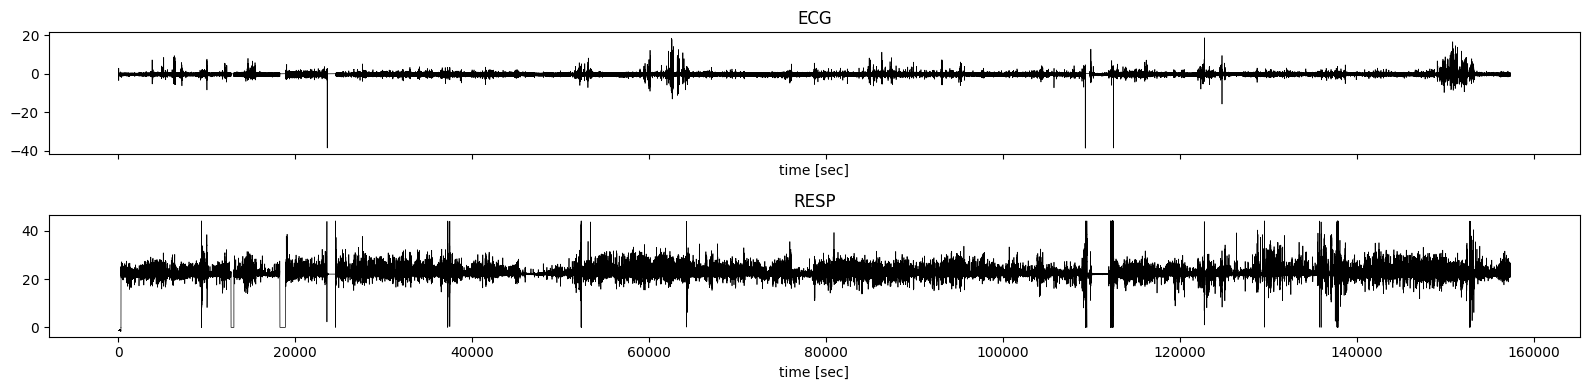

In [12]:
# plot 
# this tells the notebook to open figures outside of the notebook
#%matplotlib qt
%matplotlib inline

time_ecg = np.arange(x_ecg.shape[0])*dt_ecg # ECG time axis
time_resp = np.arange(x_resp.shape[0])*dt_resp # RESP time axis

fig1, ax = plt.subplots(2, 1, figsize=(16,4), sharex=True)
ax[0].plot(time_ecg[t0_sample_ecg:t1_sample_ecg], x_ecg[t0_sample_ecg:t1_sample_ecg], '-k', lw=0.5)
ax[1].plot(time_resp[t0_sample_resp:t1_sample_resp], x_resp[t0_sample_resp:t1_sample_resp], '-k', lw=0.5)
ax[0].set_xlabel("time [sec]")
ax[1].set_xlabel("time [sec]")
ax[0].set_title("ECG")
ax[1].set_title("RESP")
plt.tight_layout()
plt.show()

## PART2 Selection of sample segments
Use the manually selected segment borders (in seconds) that were identified
**Can add a random function here** 
List item
List item
visually using picsdb1_inspect.ipynb: 

In [13]:
# A
segments = {}
for i in range(10):
    key = f"infant{i+1:d}"
    segments[key] = []
# segments['infant1'] = [(3550, 3750), (4720,4822), (5100,5280), (7760,7870), (11435,11550)]
# segments['infant1'] = [(3550,7870)]
# segments['infant2'] = [(3990,12080)]
# #segments['infant1'] = [(5110,5355)]
# #segments['infant2'] = [(3955,3960)]
# segments['infant3'] = [(5575,13940)]
# segments['infant4'] = [(5860,12980)]
# segments['infant5'] = [(103750,147350)] #FINAL
# segments['infant6'] = [(7130,13670)]
# segments['infant7'] = [(5060,13630)]
# segments['infant8'] = [(4880,14570)]
# segments['infant9'] = [(5940,12580)]
# segments['infant10'] = [(3225,14710)]
segments['infant1'] = [(3550, 3750), (4720,4822), (5100,5280), (7760,7870), (11435,11550)]
segments['infant2'] = [(3990,4090), (9440,9580), (9770,9890), (11940,12080), (12180,12350)]
segments['infant3'] = [(5575,5760), (10200,10340), (10400,10600), (13300,13500), (13700,13940)]
segments['infant4'] = [(5860,6020), (6695,6810), (6900,7020), (8350,8450), (12750,12980)]
segments['infant5'] = [(103750,104000), (121275, 121375), (122475,122575), (146500,146600), (147050,147350)]
segments['infant6'] = [(7130,7230), (7350,7530), (11440,11600), (13290,13390), (13530,13670)]
segments['infant7'] = [(5060,5190), (5480,5590), (9150,9450), (9500,9675), (13420,13630)]
segments['infant8'] = [(4880,5000), (5040,5140), (6690,6790), (7500,7700), (14440,14570)]
segments['infant9'] = [(5940,6040), (7620,7740), (11120,11220), (11540,11640), (12400,12580)]
segments['infant10'] = [(3225,3400), (9500,9700), (10150,10350), (14500,14600), (14610,14710)]

## PART3 Select thresholds for peak detection for each sample
Part 3 will be re-ran every segement. The final thresholds selected will be recorded in columns D to K of 'Preterm Infant Data Input Settings Blank' excel spreadsheet.

Our complete and filled out excel spreadsheet is titled 'Preterm Infant Data Input Settings'. Refer to that if wanting to produce our exact results.

### Step One: Select segement to work with

Select a segment to work with by entering in an Infant number/ file_index (1 to 10) and a segement number

file_index = 2 # 1...10, loads data from infant1 ... infant10 segment_index = 0

In [14]:
file_index = 2 # 1...10, loads data from infant1 ... infant10
segment_index = 0 # 0,...

## Step two: Import all the revelent data for that segement
Similar to part 1, the data will be imported but only part of the signal. Part 2, Step Two created a dictionary that will be used so the correct segment of time is selected from the overall signal and Part 3, Step One determines which segment it is.

In [46]:
# Data Import
x_ecg_full, x_resp_full, fs_ecg, fs_resp = load_waveforms(data_dir, file_index)
dt_ecg = 1/fs_ecg # ECG sampling interval in sec.
dt_resp = 1/fs_resp # RESP sampling interval in sec.
print("ECG sampling interval dt = ", dt_ecg, " sec.")
print("RESP sampling interval dt = ", dt_resp, " sec.")

Loading ECG file:  infant2_ecg
Loading RESP file:  infant2_resp
ECG sampling frequency:  500  Hz
RESP sampling frequency:  50  Hz
ECG sampling interval dt =  0.002  sec.
RESP sampling interval dt =  0.02  sec.


*Clip* data to segment borders:

In [17]:
# get segment borders in seconds from the 'segments' dictionary
t0_sec, t1_sec = segments[f"infant{file_index:d}"][segment_index]
# convert seconds to samples, respect different sampling rates for ECG and RESP signals
t0_sample_ecg = round(t0_sec * fs_ecg)
t1_sample_ecg = round(t1_sec * fs_ecg)
t0_sample_resp = round(t0_sec * fs_resp)
t1_sample_resp = round(t1_sec * fs_resp)

In [18]:
print(t0_sample_ecg)
print(t1_sample_ecg)
print(t0_sample_resp)
print(t1_sample_resp)

1995000
2045000
199500
204500


In [19]:
# Extract the ECG and RESP data arrays and convert them to a 1-dimensional arrays:
x_ecg = x_ecg_full[t0_sample_ecg:t1_sample_ecg] #sample for ecg
x_resp = x_resp_full[t0_sample_resp:t1_sample_resp]
print("number of ECG samples: ", len(x_ecg) , " data type: ", x_ecg.dtype)
print("number of RESP samples: ", x_resp.shape[0], " data type: ", x_resp.dtype)


number of ECG samples:  50000  data type:  float64
number of RESP samples:  5000  data type:  float64


In [20]:
del x_ecg_full, x_resp_full # free memory

Invert ECG signal if necessary.

mn = np.min(x_ecg-np.median(x_ecg)) mx = np.max(x_ecg-np.median(x_ecg)) if np.abs(mn) > np.abs(mx): print("Invert ECG signal!") x_ecg = -x_ecg

### Step Three: Plot the signal to check the segment selected

In [21]:
# open figures outside of the notebook
#%matplotlib qt
%matplotlib inline

# ECG/RESP time axes [sec]
time_ecg = np.arange(x_ecg.shape[0])*dt_ecg
time_resp = np.arange(x_resp.shape[0])*dt_resp

Step Four: Define a few functions to process the signal with

A) Bandwidth filter (filters out extreme frequency signals that are out of what's is physically possible)
B) Local Maxima- to detect the peak of a wave
C) Histogram- to look at distribution
D) Interval Statistics
NOTE: These functions have been moved from the notebook into the external file picsdb.py

# ECG/RESP peak detection algorithm

*   **List item**
*   List item

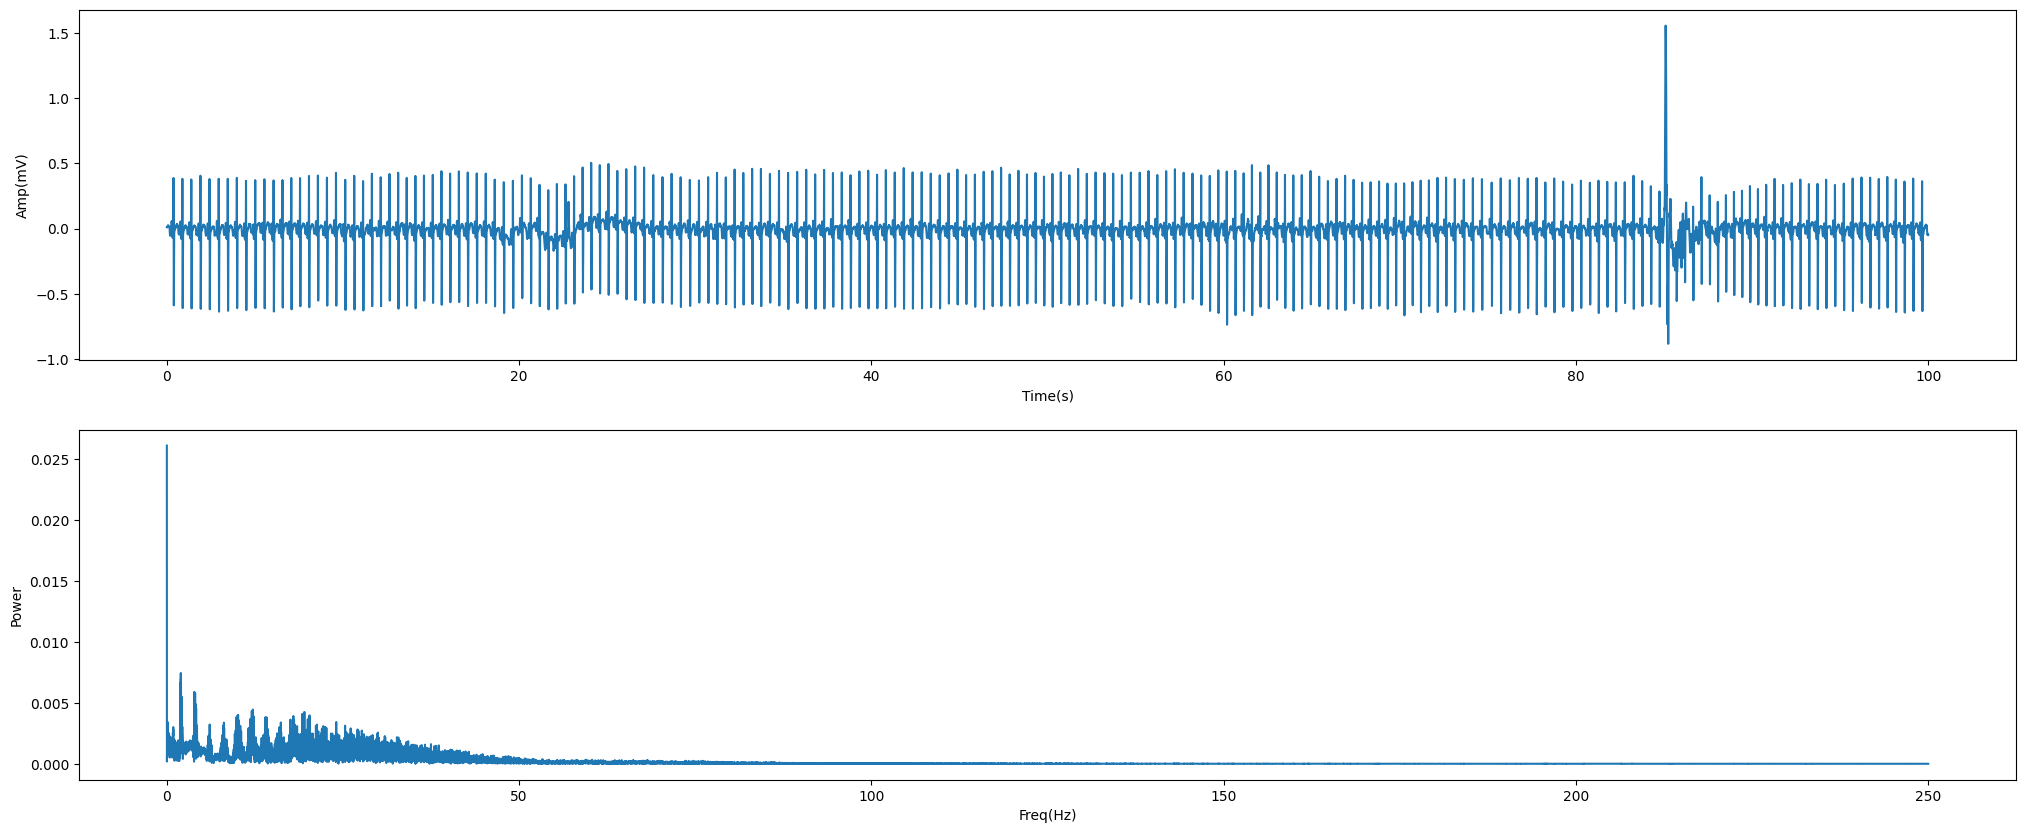

In [22]:
x=x_ecg
iSampleCount=x.shape[0]
iSampleRate=fs_ecg
t = np.linspace(0,iSampleCount/iSampleRate,iSampleCount)
 
xFFT = np.abs(np.fft.rfft(x)/iSampleCount)  #快速傅里叶变换
#xFreqs = np.linspace(0, iSampleRate/2, int(iSampleCount/2)+1)
xFreqs = np.linspace(0, iSampleRate/2, int(iSampleCount/2)+1)
plt.figure(figsize=(25,10))
ax0 = plt.subplot(211)             #画时域信号
ax0.set_xlabel("Time(s)")
ax0.set_ylabel("Amp(mV)")
ax0.plot(t,x)
 
ax1 = plt.subplot(212)             #画频域信号-频谱
ax1.set_xlabel("Freq(Hz)")
ax1.set_ylabel("Power")

ax1.plot(xFreqs, xFFT)


# Plot power spectra

First, inspect the power spectral densities of ECG/RESP signals to get an idea of useful settings for the band-pass filters.

**Step Five: Define cut-off frequencies for ECG and RESP signals**

These cut-off frequencies are chosen based off a combination of what is physiologically possible and the sampling frequency of the signal. They should be kept the same across all infants HOWEVER infant 1 and 5's ECG sampling rate was 250Hz instead of 500Hz. Therefore, we had to lower the freq_hi_ecg setting to 120Hz, as the value must be less than half the sampling rate. The rest of the infants freq_hi_ecg was 125Hz.

The following cell allows you to check if your settings work for the sample. Record the settings in column D, E, F and G in 'Preterm Infant Data Input Settings Blank'.

In [23]:
freq_lo_ecg = 20
freq_hi_ecg = 125 # if is 1 or 5, use 120
freq_lo_resp = 0.5
freq_hi_resp = 5 # 5

**Step Six: Apply the band-pass filter**

Using the function defined in step 4, A and the settings defined in step 5, a band-pass filter is created and applied to further filter out any signals that could be aretfacts/ background.

In [24]:
x_ecg_filt  = bp_filter(x_ecg, fs_ecg, freq_lo_ecg, freq_hi_ecg)
x_resp_filt = bp_filter(x_resp, fs_resp, freq_lo_resp, freq_hi_resp)

In [25]:
x_resp_filt_re=processing.resample_sig(x_resp_filt,fs=50,fs_target=500)[0]
from scipy import signal

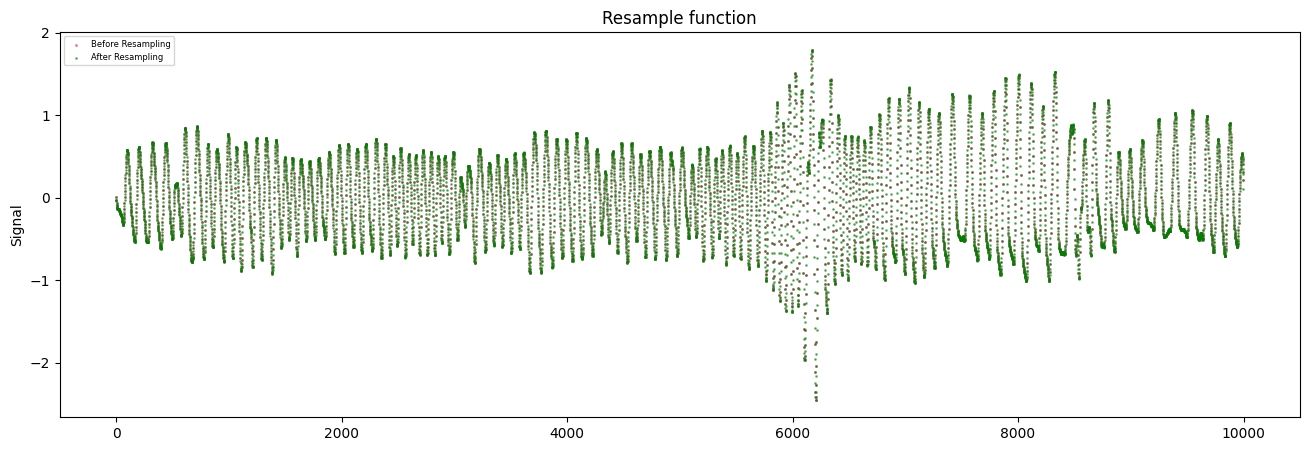

In [26]:
testresp=x_resp_filt
plt.figure(figsize=(16,5))
time=np.arange(2*len(testresp),step=2)
plt.scatter(time, testresp, color = 'hotpink',s=1,label='Before Resampling')
#plt.scatter(time_resp, x_resp, color = '#88c999')
i=np.array(testresp)
res=processing.resample_sig(i,fs=500,fs_target=1000)
plt.ylabel("Signal")
time=np.arange(2*len(testresp))
plt.scatter(time, res[0], color = 'green',s=1,alpha=0.5,label='After Resampling')
plt.legend(labels=["Before Resampling","After Resampling"],loc="upper left",fontsize=6)  
plt.title("Resample function")
plt.show()

Resample the ecg sig

base on ecg and resp freq

In [27]:
x_resp_filt=processing.resample_sig(x_resp_filt,fs=50,fs_target=500)[0]
x_ecg=x_ecg_filt
print(len(x_resp_filt))
print(len(x_ecg))

50000
50000


get the single resp wave

C:\Users\Flynn\AppData\Local\Temp\ipykernel_10588\3392795584.py:47: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


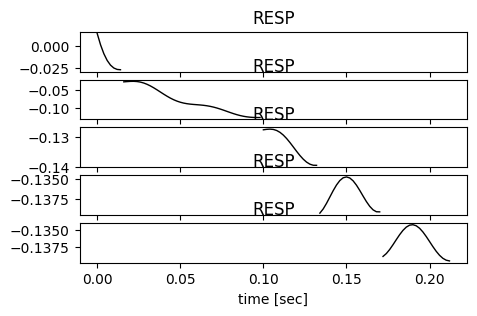

In [28]:
x_resp_flow=[]
floewer=[]

x_ecg_flow=[]
ecg_flow=[]


time_resp_temp=time_ecg
time_ecg_temp=time_resp

x_temp=[]
temp=[]
for i in range(0,len(x_resp_filt)-1,1):
    if i==0:
        floewer.append(x_resp_filt[i])
        ecg_flow.append(x_ecg[i])
        temp.append(time_resp_temp[i])
        #ecg.append(time_ecg_temp[i])
    else:
        floewer.append(x_resp_filt[i])
        temp.append(time_resp_temp[i])
        ecg_flow.append(x_ecg[i])
        #ecg.append(time_resp_temp[i])
        if not (x_resp_filt[i]<x_resp_filt[i+1] and x_resp_filt[i]<=x_resp_filt[i-1]):
            pass
        else:
            x_resp_flow.append(floewer)
            x_ecg_flow.append(ecg_flow)
            x_temp.append(temp)
            #ecg_temp.append(ecg)
            floewer=[]
            ecg_flow=[]
            temp=[]
            #ecg=[]
lens=len(x_temp)
fig2, ax = plt.subplots(5, 1, figsize=(5,3), sharex=True)
#x_resp_flow.remove(x_resp_flow[0])
#x_temp.remove(x_temp[0])
#x_ecg_flow.remove(x_ecg_flow[0])
j=0
for i in range(0,5):
    ax[j].plot(x_temp[i], x_resp_flow[i], '-k', lw=1)
    ax[j].set_xlabel("time [sec]")
    ax[j].set_title("RESP")
    j+=1

plt.tight_layout()
plt.show()

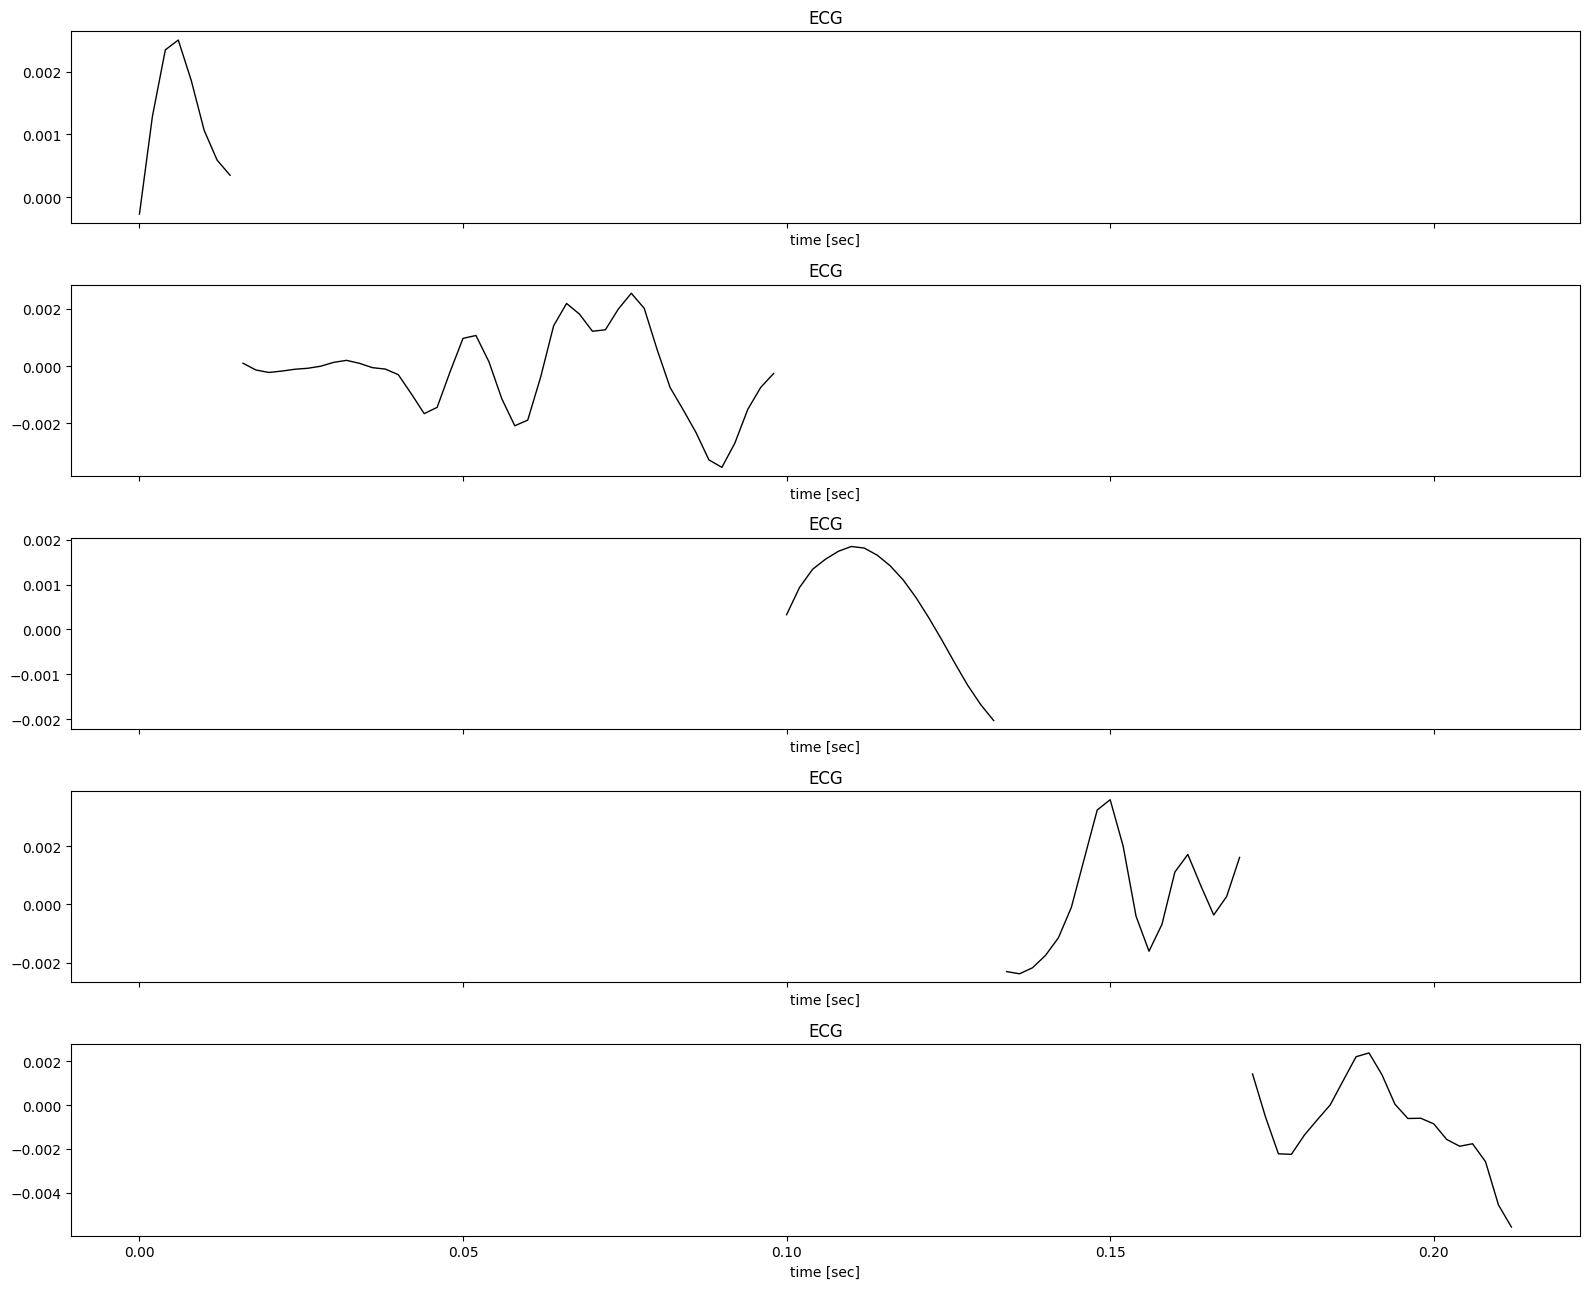

In [29]:
fig2, ax = plt.subplots(5, 1, figsize=(16,13), sharex=True)
j=0
for i in range(0,5):
    ax[j].plot(x_temp[i], x_ecg_flow[i], '-k', lw=1)
    ax[j].set_xlabel("time [sec]")
    ax[j].set_title("ECG")
    j+=1
plt.tight_layout()
plt.show()

conbain the uncontinue data

remove some data

I still working on finding someway to fix the discontinuous data, so I drop them.

If we can combain the discontinuous data, this function can be delete

In [30]:
for i in x_resp_flow:
    if(len(i)<200):
        x_resp_flow.remove(i)

for j in x_ecg_flow:
    if(len(j)<200):
        x_ecg_flow.remove(j)

for z in x_temp:
    if(len(z)<200):
        x_temp.remove(z)

In [31]:
# find the R wave for each part ecg wave
lomx=[]
w=1
for z in x_ecg_flow:
    c=locmax(z)
    ecg_peaks = np.array([np.mean(z[i-w:i+w]) for i in c])
    c = np.array([j for i, j in enumerate(c) if ecg_peaks[i] > 0.12]) #ecg_peacks > 0.12 / 0.2
    lomx.append(c)
print(len(lomx))

121


In [32]:
lomx

[array([], dtype=float64),
 array([], dtype=float64),
 array([83, 99], dtype=int64),
 array([134, 150, 387, 403], dtype=int64),
 array([130, 146, 389, 404], dtype=int64),
 array([ 68,  83, 324, 340], dtype=int64),
 array([  8,  24, 269, 285], dtype=int64),
 array([ 20,  36, 281, 296], dtype=int64),
 array([146, 162, 398, 414], dtype=int64),
 array([172, 187, 420, 436], dtype=int64),
 array([143, 159], dtype=int64),
 array([  3,  19, 260, 276], dtype=int64),
 array([ 20,  35, 282, 298], dtype=int64),
 array([146, 162], dtype=int64),
 array([ 26,  41, 276, 291], dtype=int64),
 array([ 19,  35, 269, 284], dtype=int64),
 array([112, 128, 355, 371], dtype=int64),
 array([135, 151, 378, 394], dtype=int64),
 array([226, 242], dtype=int64),
 array([127, 143], dtype=int64),
 array([ 21,  37, 272, 287], dtype=int64),
 array([114, 130, 369, 385], dtype=int64),
 array([232, 248], dtype=int64),
 array([ 37,  52, 294, 310], dtype=int64),
 array([124, 140, 380, 396], dtype=int64),
 array([207, 222], 

In [33]:
# compute the rate for each ecg wave
timespan=2 #ms
rate=[]
for i in lomx:
    if not len(i)==0:
        span=2*(max(i)-min(i))/(len(i)-1)
        rate.append(60000/span)
    else:
        rate.append(0)

In [34]:
rate

[0,
 0,
 1875.0,
 334.5724907063197,
 328.46715328467155,
 330.88235294117646,
 324.9097472924188,
 326.0869565217391,
 335.82089552238807,
 340.90909090909093,
 1875.0,
 329.6703296703297,
 323.74100719424456,
 1875.0,
 339.622641509434,
 339.622641509434,
 347.4903474903475,
 347.4903474903475,
 1875.0,
 1875.0,
 338.3458646616541,
 332.10332103321036,
 1875.0,
 329.6703296703297,
 330.88235294117646,
 2000.0,
 340.90909090909093,
 347.4903474903475,
 1875.0,
 348.83720930232556,
 1875.0,
 335.82089552238807,
 1875.0,
 1875.0,
 1875.0,
 323.74100719424456,
 1875.0,
 1875.0,
 327.27272727272725,
 1875.0,
 340.90909090909093,
 242.914979757085,
 239.0438247011952,
 235.2941176470588,
 233.46303501945525,
 232.5581395348837,
 233.46303501945525,
 334.5724907063197,
 338.3458646616541,
 338.3458646616541,
 337.07865168539325,
 1875.0,
 332.10332103321036,
 329.6703296703297,
 2000.0,
 337.07865168539325,
 1875.0,
 338.3458646616541,
 343.5114503816794,
 1875.0,
 342.20532319391634,
 347.

In [53]:
arr = np.nan_to_num(rate)
arr
processedRateArr = arr

In [54]:
nanlist=[]
for i in range(len(arr)):
    if arr[i]<70 or arr[i]>190:
        nanlist.append(i)

In [55]:
finalrate=[]
j=0
for i in range(len(arr)):
    if j==len(nanlist):
        break
    if i==nanlist[j]:
        j+=1
        pass
    else:
        finalrate.append(arr[i])

In [72]:
len(finalrate)
finalrate

[126.05042016806723]

In [57]:
finalresp=[]
j=0
for i in range(len(x_resp_flow)):
    if j==len(nanlist):
        break
    if i==nanlist[j]:
        j+=1
        pass
    else:
        finalresp.append(x_resp_flow[i])

In [58]:
# remove incomplete ecg data for resp and ecg wave
# fffff - > final resp with 500hz resampled
# ffflow -> final resp resampled from 500hz to ?  ; values
# ttttt -> final resp resampled from 500hz to ? ; locations
fffflow=[]
fffffff=np.array(finalresp)
ttttttt=[]

In [60]:
for i in fffffff:
    i=np.array(i)
    res=processing.resample_sig(i,fs=500,fs_target=(200000/len(i)))
    vbcx=res[0]
    ttttttt.append(res[1])
    fffflow.append(vbcx)

In [61]:
import pandas as pd

In [62]:
for i in fffflow:
    i=i[0:399]
for j in ttttttt:
    j=j[0:399]

In [63]:
len(fffflow)


print(fffflow)

[array([-9.78356803e-01, -9.76843535e-01, -9.76104731e-01, -9.72634529e-01,
       -9.70873633e-01, -9.66035246e-01, -9.63098879e-01, -9.56977149e-01,
       -9.52848314e-01, -9.45488952e-01, -9.40182118e-01, -9.31627032e-01,
       -9.25172090e-01, -9.15466982e-01, -9.07905227e-01, -8.97102486e-01,
       -8.88485709e-01, -8.76646060e-01, -8.67036512e-01, -8.54229923e-01,
       -8.43700163e-01, -8.30005889e-01, -8.18638024e-01, -8.04143720e-01,
       -7.92027877e-01, -7.76827909e-01, -7.64060157e-01, -7.48253482e-01,
       -7.34933604e-01, -7.18621716e-01, -7.04851306e-01, -6.88136669e-01,
       -6.74017879e-01, -6.57003087e-01, -6.42638109e-01, -6.25425682e-01,
       -6.10916749e-01, -5.93609264e-01, -5.79058754e-01, -5.61758838e-01,
       -5.47269037e-01, -5.30078837e-01, -5.15751040e-01, -4.98770962e-01,
       -4.84703873e-01, -4.68030704e-01, -4.54318356e-01, -4.38043116e-01,
       -4.24772769e-01, -4.08978772e-01, -3.96229245e-01, -3.80990799e-01,
       -3.68831575e-01, 

In [64]:
import csv

with open("test_02.csv","w", newline="") as csvfile: 
    writer = csv.writer(csvfile)
    writer.writerows(fffflow)
    writer.writerows(ttttttt)
    
    


In [ ]:
# Export processed infant 2 data

In [71]:
# processedRateLabelledArr = []
# for i in processedRateArr:
#   i = np.round(i)
#   if i > 140 or i < 120 
#   print(i)
    
    
with open('ecg_all.csv', 'w', newline="") as csvfile:
  writer = csv.writer(csvfile)
  writer.writerows([processedRateArr])


0.0
0.0
1875.0
335.0
328.0
331.0
325.0
326.0
336.0
341.0
1875.0
330.0
324.0
1875.0
340.0
340.0
347.0
347.0
1875.0
1875.0
338.0
332.0
1875.0
330.0
331.0
2000.0
341.0
347.0
1875.0
349.0
1875.0
336.0
1875.0
1875.0
1875.0
324.0
1875.0
1875.0
327.0
1875.0
341.0
243.0
239.0
235.0
233.0
233.0
233.0
335.0
338.0
338.0
337.0
1875.0
332.0
330.0
2000.0
337.0
1875.0
338.0
344.0
1875.0
342.0
347.0
251.0
248.0
1875.0
340.0
2000.0
1875.0
335.0
2000.0
1875.0
337.0
2000.0
337.0
1875.0
1875.0
1875.0
2000.0
2000.0
1875.0
359.0
2000.0
1875.0
1875.0
346.0
1875.0
1875.0
1875.0
352.0
353.0
354.0
359.0
255.0
248.0
288.0
330.0
232.0
337.0
337.0
336.0
338.0
346.0
1875.0
294.0
347.0
857.0
126.0
357.0
364.0
370.0
370.0
354.0
346.0
1875.0
346.0
1875.0
336.0
345.0
349.0
341.0
1875.0
